In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')
import random
import PreEmo
import DestiRec

from selection import *
from deap import algorithms, base, benchmarks, tools, creator
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
warnings.filterwarnings("ignore", 'invalid value encountered in true_divide')
warnings.filterwarnings("ignore", 'A class named ')

pd.options.mode.chained_assignment = None
import evaluation

Assuming given user Input
Duration = 5 weeks
Budget = 4000
Unwanted Regions = [Afghanistan, Pacific]
Preference activities = [hiking, beach, watersports, culinary, entertainment]
Preferred Travel Months = [apr, may, jun]

### Now pre-initialization

First we use the similarity metric to get a ranking of regions
$$
\begin{align*}
sim_{feature} (f_q, f_c) = 1 - \frac{\lvert f_q - f_c \rvert} {max(f_q , f_c)}
\end{align*}
$$

$$
\begin{align*}

similarity (q, c) = \frac{\sum_{i=1}^{n} w_i * sim_i(q_i, c_i)} {\sum_{i=1}^{n} w_i}
\end{align*}
$$

similarity current region and given input
all possible preferences is n
f_q = 1
f_c = actual score for preference i



We do a Max Min Normalization of the scores 

$$
\begin{align*}
X_{ij} = \frac{X_{ij} - X_j^{min}}{X_j^{max}-X_j^{min}}
\end{align*}
$$

Implementing the Moop Problem

$$
\begin{align*}maximize \qquad  &z_k(x) = \sum_{i=1}^n x_i\ s_{ik}, \hspace{1cm} k = 1,...,p \\
    subject \ to \qquad &\sum_{i=1}^n x_i d_i  \leq D \\
    &\sum_{i=1}^n x_i\ b_i \leq B \\
    &\sum_{j \in N} x_{ij} \geq 1 \\ 
    &g_{il}(x_i) \leq \delta,  \hspace{1cm} \forall \ 1 \leq i < l \leq n  \\
    x_i \in \{0,1\}, \qquad &\forall \ 1 \leq i \leq n
\end{align*}
$$

$$ f^\mathrm{penalty}_i(\mathbf{x}) = \Delta_i - w_i d_i(\mathbf{x}) $$

Possible  Categories

['oct' 'beach' 'watersports' 'entertainment' 'wintersports' 'culture'
 'culinary' 'cities & architecture' 'shopping' 'jan' 'feb' 'mar' 'apr'
 'may' 'jun' 'jul' 'aug' 'sep' 'nov' 'dec' 'hiking' 'nature & wildlife'
 'Safety from crime' 'Weeks to Lower Quantile' 'Weeks to Upper Quantile'
 'average weekly cost']

In [84]:
evaluation.run()

gen	evals	std	min	avg	maxsses


C:\Users\suzzy\AppData\Local\Temp\ipykernel_8004\3001870509.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(np.arange(max-1), means, std, fmt='ok', lw=3, ecolor='black', color='red')
C:\Users\suzzy\AppData\Local\Temp\ipykernel_8004\3001870509.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(np.arange(max-1), means, [means - mins, maxes- means],


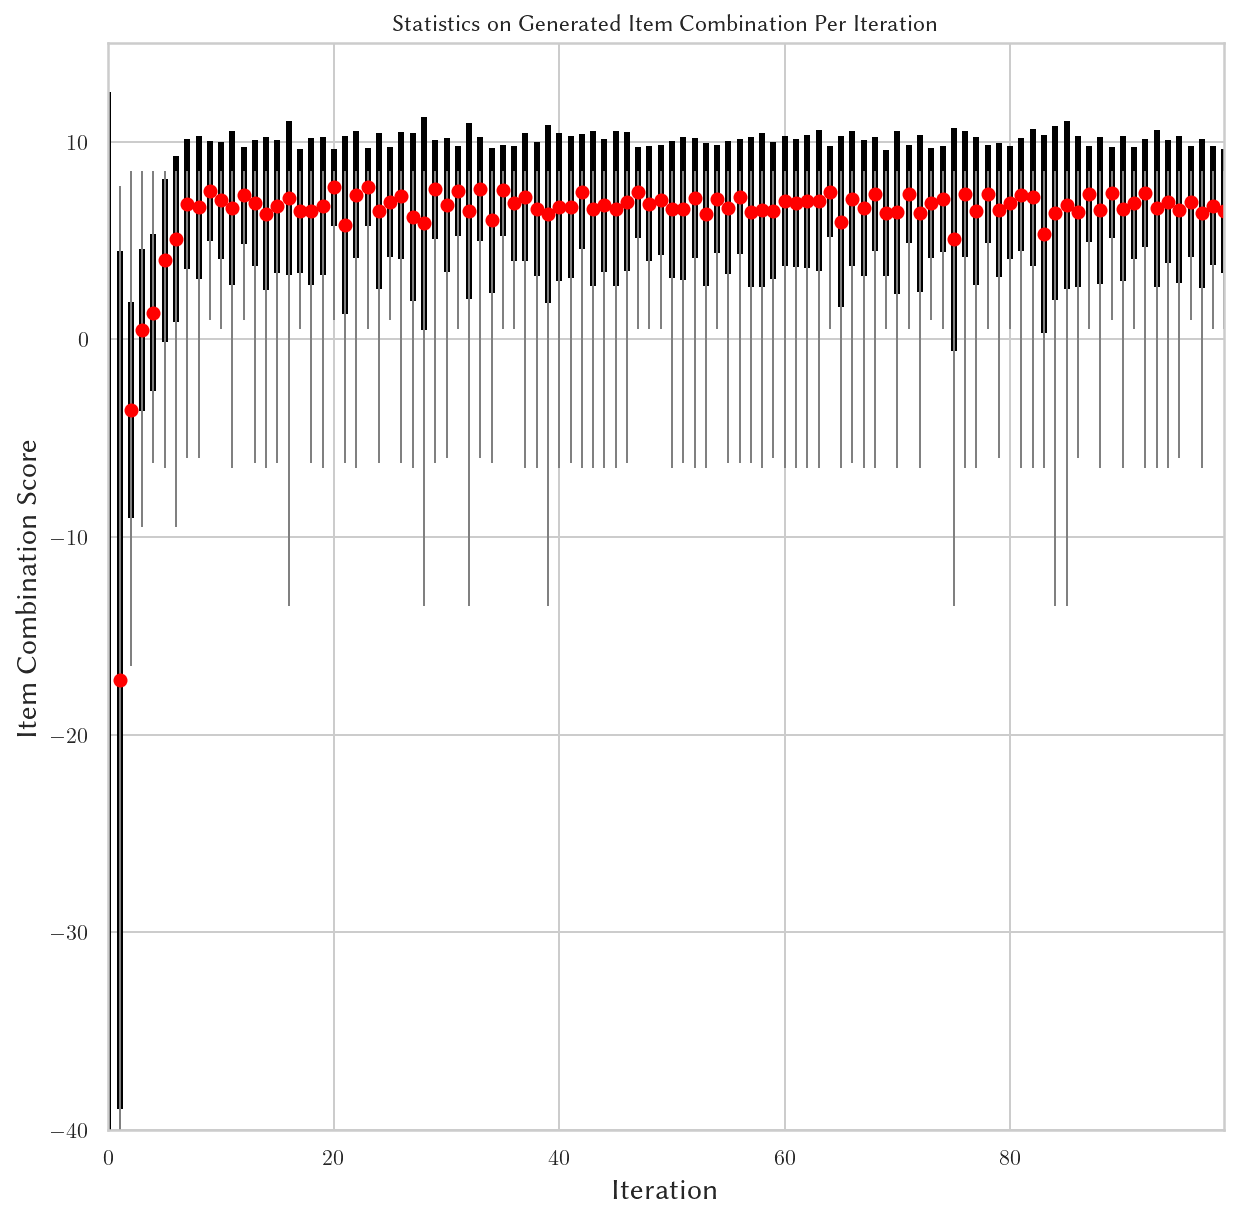

In [82]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
mins = []
maxes = []
means = []
std = []
for i, gen in enumerate(result['Process']):    
    df = pd.DataFrame(gen['fitnesses'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna(subset=[x for x in range(obj)], how="all")
    sums = df.sum(axis=1)
    means.append(sums.mean())
    mins.append(sums.min())
    maxes.append(sums.max())
    std.append(sums.std())

mins = np.array(mins)
maxes = np.array(maxes)
means = np.array(means)
std = np.array(std)
ax.errorbar(np.arange(max-1), means, std, fmt='ok', lw=3, ecolor='black', color='red')
ax.errorbar(np.arange(max-1), means, [means - mins, maxes- means],
            fmt='.k', ecolor='gray', lw=1, color='red')
plt.xlim(0, 99)
plt.ylim(-40, 15)
#plt.yticks([0.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Item Combination Score', fontsize=15)
#plt.autoscale(tight=True) 
ax.set_title('Statistics on Generated Item Combination Per Iteration')   
plt.savefig(f'logs/results/statistics {toolbox.experiment_name}.png')
#maean = black
#std=blue


In [13]:
import seaborn as sns

C:\Users\suzzy\AppData\Local\Temp\ipykernel_8004\1561506327.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x) for x in xlabels])


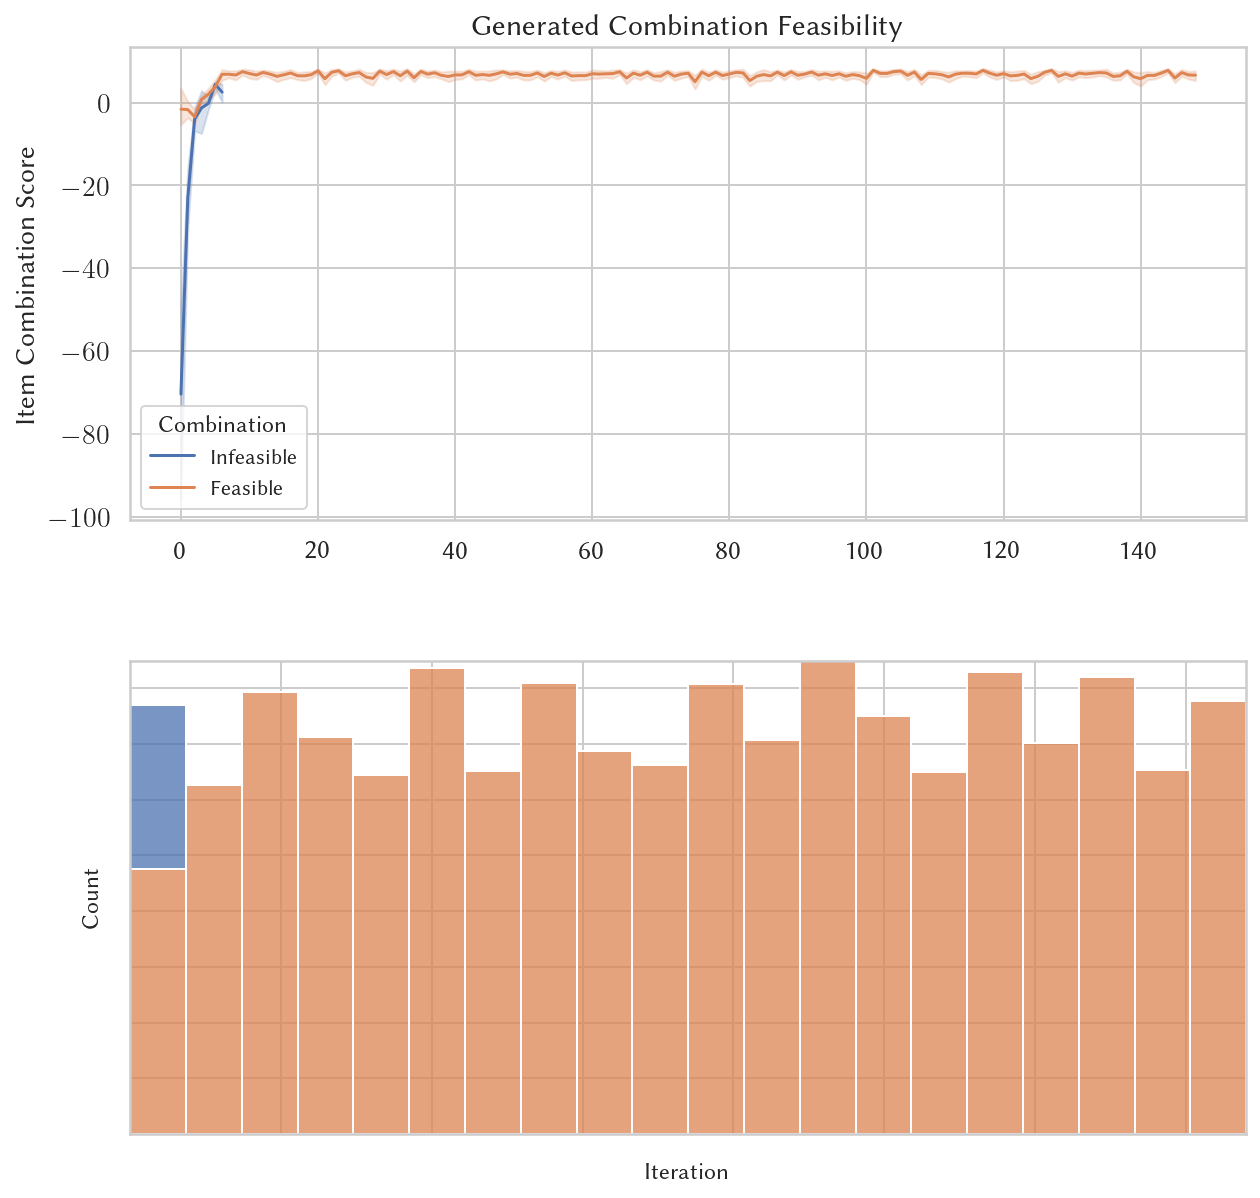

In [83]:
fig = plt.figure(figsize=(10,10))
spec = fig.add_gridspec(2, 2, hspace=0.3)
ax = fig.add_subplot(spec[0, :])
ax2 = fig.add_subplot(spec[1, :], xticklabels=[], yticklabels=[])
main_df = pd.DataFrame()
for i, gen in enumerate(result['Process']):    
    df = pd.DataFrame(gen['feasibility'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna(subset=[0, 1], how="all")
    df['Iteration'] = i
    if(main_df.empty):
        main_df = df
    else:
        main_df = pd.concat([main_df, df], ignore_index=True)
main_df = main_df.rename(columns={1:'Combination'})
sns.lineplot(data = main_df, x = 'Iteration', y = 0, hue='Combination',
               ax=ax)
sns.histplot(main_df, x='Iteration', hue='Combination', multiple='stack', ax=ax2, legend=False)  
ax.set(xlabel='', ylabel='Item Combination Score', title='Generated Combination Feasibility')
ax.title.set_fontsize(15) 
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

xlabels = ax.get_xticks().tolist()
ax.set_xticklabels([int(x) for x in xlabels])
ax.set_y

plt.autoscale(tight=True) 

plt.savefig(f'logs/results/feasbility {toolbox.experiment_name}.png')

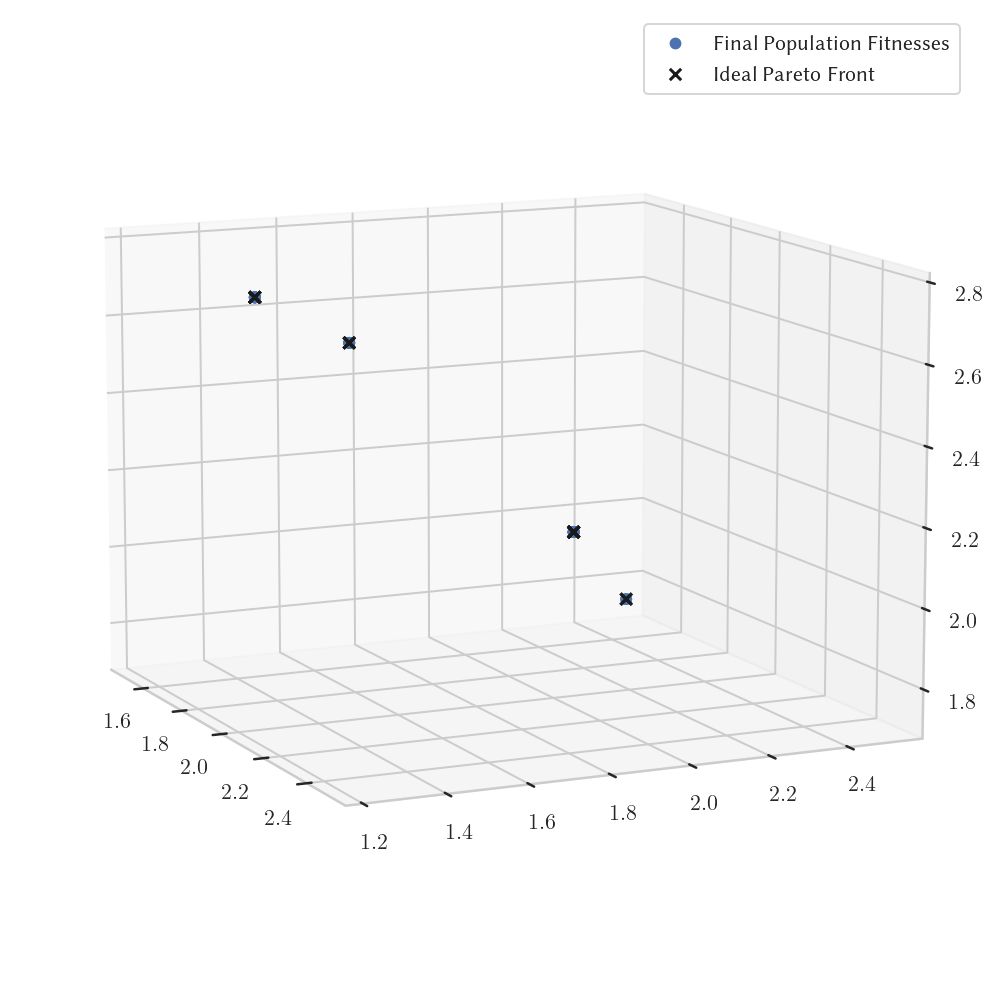

In [30]:
#pop_fit = np.array([ind.fitness.values for ind in population])

f = tools.emo.sortLogNondominated(population, len(population), first_front_only=True)
pf = np.array([ind.fitness.values for ind in f])
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3d

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

p = np.array([ind.fitness.values for ind in population])
ax.scatter(p[:, 0], p[:, 1], p[:, 2], marker="o", s=24, label="Final Population Fitnesses")

ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], marker="x", c="k", s=32, label="Ideal Pareto Front")

#ref_points = tools.uniform_reference_points(3, p=ref)
#ax.scatter(ref_points[:, 0], ref_points[:, 1], ref_points[:, 2], marker="o", s=24, label="Reference Points")

ax.view_init(elev=11, azim=-25)
ax.autoscale(tight=True)
plt.legend()
plt.tight_layout()
plt.savefig("nsga3.png")
plt.savefig(f'logs/results/Visual Result {toolbox.experiment_name}.png')

In [ ]:
fronts = tools.emo.sortLogNondominated(population, len(population))


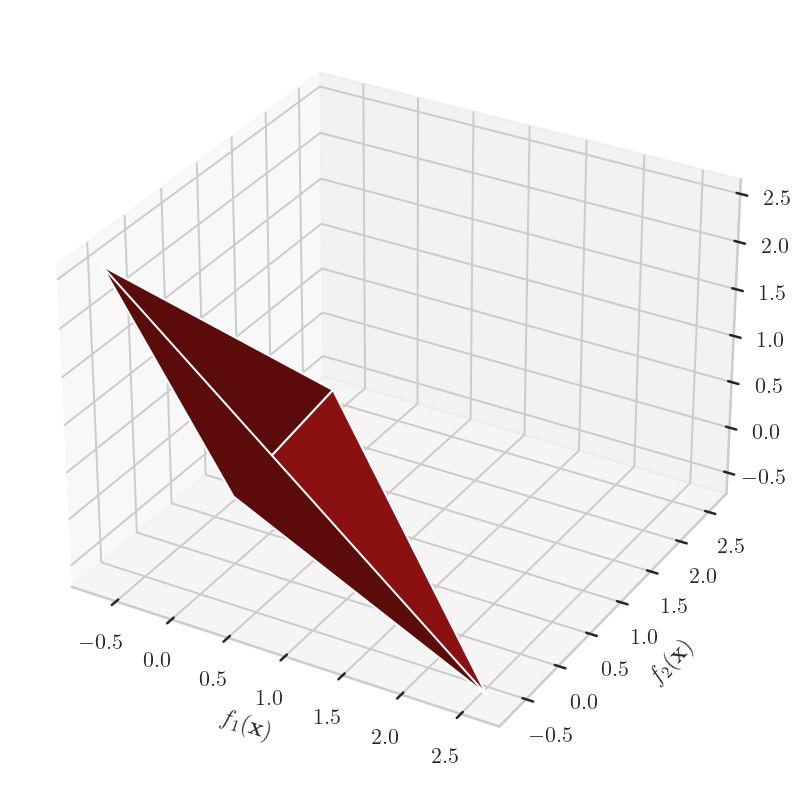

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
plot_colors = seaborn.color_palette("Set1", n_colors=10)
#fig, ax = plt.subplots(1, figsize=(4,4))
for i,inds in enumerate(fronts):
    evaluatedfront = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(evaluatedfront)
    ax.plot_trisurf(df[0].values, df[1].values, df[2].values,color=plot_colors[i], label='Front ' + str(i+1))
   
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');